## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## DoubleConv Block (U-Net)

The `DoubleConv` module is a **basic building block of the U-Net architecture**. It applies **two consecutive convolutional operations** to extract richer spatial features from the input.

### Structure
Each block follows the pattern:

**Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → ReLU**

- **3×3 Convolutions** with padding preserve the spatial resolution.
- **Batch Normalization** stabilizes and speeds up training.
- **ReLU activation** introduces non-linearity.
- `bias=False` is used because BatchNorm already includes a bias term.

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

## Down Block (Encoder Block in U-Net)

The `Down` module represents a **downsampling step in the encoder path of U-Net**. It reduces the spatial resolution while increasing the number of feature channels.

### Structure
The block consists of:

**MaxPool2D → DoubleConv**

- **MaxPool2D (2×2)**  
  - Reduces the height and width by a factor of 2.
  - Helps the network capture more global context.
- **DoubleConv**  
  - Applies two 3×3 convolutions with BatchNorm and ReLU.
  - Refines features after downsampling.

In [3]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

## Up Block (Decoder Block in U-Net)

The `Up` module performs **upsampling in the decoder path of U-Net** and combines high-level features with corresponding encoder features using **skip connections**.

### Structure
The block follows this sequence:

**Upsample → Concatenate (Skip Connection) → DoubleConv**

### Upsampling Options
- **Bilinear Upsampling (default)**  
  - Uses `nn.Upsample` to double the spatial resolution.
  - Channel reduction is handled inside `DoubleConv`.
  - More memory-efficient and smoother.
- **Transposed Convolution**  
  - Learnable upsampling using `ConvTranspose2d`.
  - Increases spatial size and reduces channels at the same time.

### Forward Pass
1. `x1` (decoder feature map) is upsampled by a factor of 2.
2. Spatial size differences between `x1` and encoder feature map `x2` are computed.
3. Padding is applied to align their sizes.
4. Encoder features (`x2`) and upsampled decoder features (`x1`) are concatenated along the channel dimension.
5. The concatenated tensor is refined using `DoubleConv`.

### Parameters
- `in_channels`: Number of channels after concatenation.
- `out_channels`: Number of output channels.
- `bilinear`: Chooses between bilinear upsampling and transposed convolution.




In [4]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

## OutConv Block (Output Layer in U-Net)

The `OutConv` module is the **final layer of the U-Net architecture**, responsible for converting extracted features into the desired output format.

### Structure
The block consists of a **1×1 convolution**:

**Conv2D (1×1)**

- The 1×1 convolution changes only the **number of channels**.
- Spatial dimensions (height and width) remain unchanged.

In [5]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## Final U-Net full architecture
![U-Net](https://idiotdeveloper.com/wp-content/uploads/2021/01/u-net-architecture.png)

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1 # nn.Upsample Upsamples only spatial size does not change channels
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## DATASET and Preprocessing

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet

## Loss function define

In [17]:
def calculate_iou(predictions, masks, num_classes=3):
    """Calculate Mean IoU"""
    ious = []
    predictions = predictions.cpu().numpy()
    masks = masks.cpu().numpy()

    for cls in range(num_classes):
        pred_cls = (predictions == cls)
        mask_cls = (masks == cls)

        intersection = np.logical_and(pred_cls, mask_cls).sum()
        union = np.logical_or(pred_cls, mask_cls).sum()

        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        ious.append(iou)

    return np.mean(ious)

In [19]:

# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 8
LEARNING_RATE = 0.001
IMAGE_SIZE = 256
NUM_CLASSES = 3

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.PILToTensor(),
])

# Load dataset
full_dataset = OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types='segmentation',
    download=True,
    transform=transform,
    target_transform=target_transform
)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {train_size}, Validation samples: {val_size}")

# Initialize model (use your own UNet model here)
model = UNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device: cuda
Training samples: 2944, Validation samples: 736


## Visualizing data

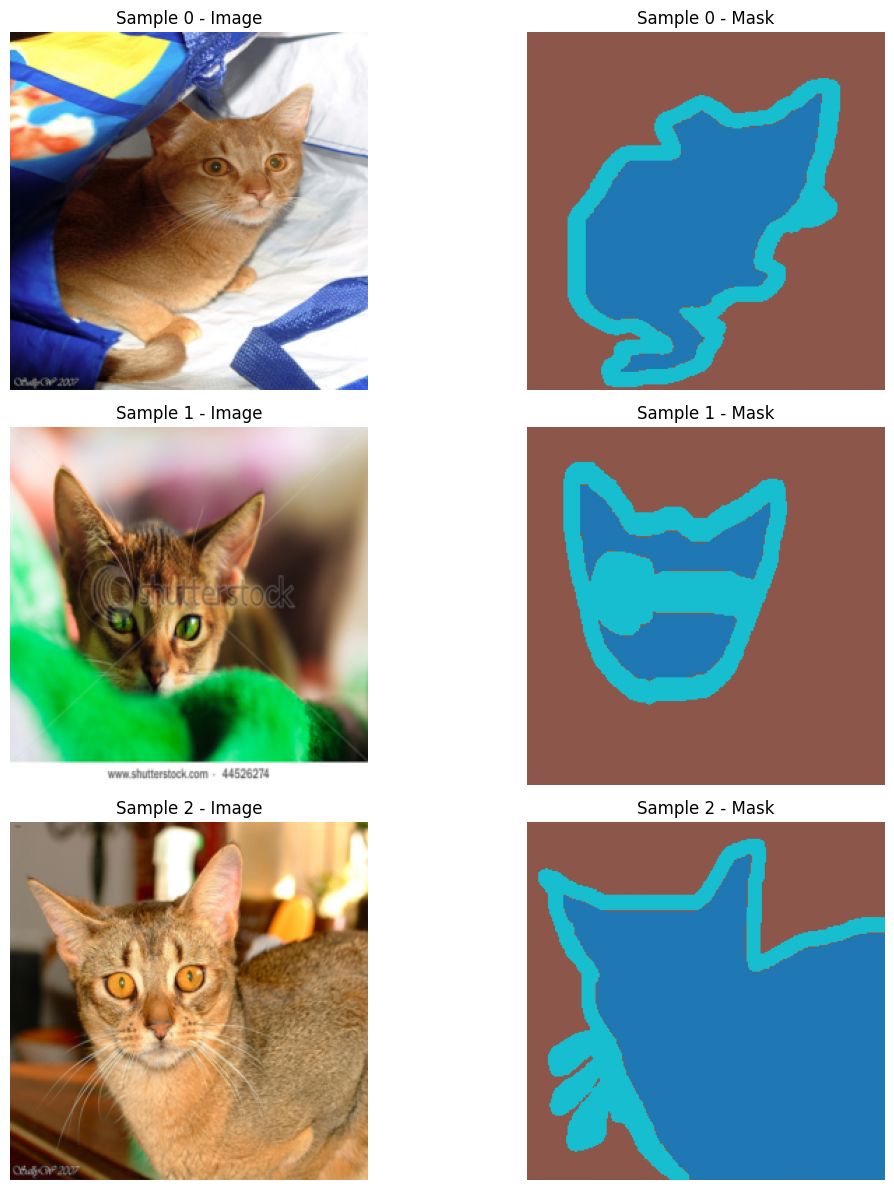

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_dataset_samples(dataset, n_samples=3):
    plt.figure(figsize=(12, n_samples * 4))

    for i in range(n_samples):
        # Fetch a single sample (image, mask)
        img_tensor, mask_tensor = dataset[i]

        # 1. Prepare Image: Convert (C, H, W) tensor to (H, W, C) numpy
        # If the dataset hasn't transformed it to a tensor yet,
        # we convert it here for the plot.
        if not isinstance(img_tensor, torch.Tensor):
            img_plot = np.array(img_tensor)
        else:
            img_plot = img_tensor.permute(1, 2, 0).cpu().numpy()
            # Rescale for display if normalized
            img_plot = (img_plot - img_plot.min()) / (img_plot.max() - img_plot.min())

        # 2. Prepare Mask
        if isinstance(mask_tensor, torch.Tensor):
            mask_plot = mask_tensor.squeeze().cpu().numpy()
        else:
            mask_plot = np.array(mask_tensor).squeeze()

        # Plotting
        plt.subplot(n_samples, 2, i*2 + 1)
        plt.imshow(img_plot)
        plt.title(f"Sample {i} - Image")
        plt.axis("off")

        plt.subplot(n_samples, 2, i*2 + 2)
        # Using 'tab10' to see the 3 classes clearly
        plt.imshow(mask_plot, cmap='tab10')
        plt.title(f"Sample {i} - Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call this with your dataset object
visualize_dataset_samples(full_dataset)

## Training

In [23]:

train_losses = []
val_losses = []
train_ious = []
val_ious = []

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    train_iou = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()
        masks = masks - 1  # Convert from {1,2,3} to {0,1,2}

        # Forward
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        train_iou += calculate_iou(predictions, masks, NUM_CLASSES)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).squeeze(1).long()
            masks = masks - 1  # Convert from {1,2,3} to {0,1,2}

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            val_iou += calculate_iou(predictions, masks, NUM_CLASSES)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_ious.append(avg_train_iou)
    val_ious.append(avg_val_iou)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
    print(f'  Train - Loss: {avg_train_loss:.4f}, IoU: {avg_train_iou:.4f}')
    print(f'  Val   - Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}')

Epoch [1/20]
  Train - Loss: 0.7227, IoU: 0.3919
  Val   - Loss: 0.7775, IoU: 0.4095
Epoch [2/20]
  Train - Loss: 0.5921, IoU: 0.4878
  Val   - Loss: 0.5308, IoU: 0.5278
Epoch [3/20]
  Train - Loss: 0.5195, IoU: 0.5450
  Val   - Loss: 0.4871, IoU: 0.5788
Epoch [4/20]
  Train - Loss: 0.4600, IoU: 0.5866
  Val   - Loss: 0.4288, IoU: 0.6069
Epoch [5/20]
  Train - Loss: 0.4257, IoU: 0.6110
  Val   - Loss: 0.4875, IoU: 0.5580
Epoch [6/20]
  Train - Loss: 0.3971, IoU: 0.6308
  Val   - Loss: 0.3875, IoU: 0.6323
Epoch [7/20]
  Train - Loss: 0.3671, IoU: 0.6518
  Val   - Loss: 0.4015, IoU: 0.6315
Epoch [8/20]
  Train - Loss: 0.3578, IoU: 0.6598
  Val   - Loss: 0.3707, IoU: 0.6604
Epoch [9/20]
  Train - Loss: 0.3432, IoU: 0.6703
  Val   - Loss: 0.3453, IoU: 0.6728
Epoch [10/20]
  Train - Loss: 0.3220, IoU: 0.6849
  Val   - Loss: 0.3264, IoU: 0.6909
Epoch [11/20]
  Train - Loss: 0.3059, IoU: 0.6970
  Val   - Loss: 0.3934, IoU: 0.6584
Epoch [12/20]
  Train - Loss: 0.2973, IoU: 0.7014
  Val   - Los

In [24]:
# Save model
torch.save(model.state_dict(), 'unet_model.pth')
print("\nTraining complete! Model saved as 'unet_model.pth'")


Training complete! Model saved as 'unet_model.pth'


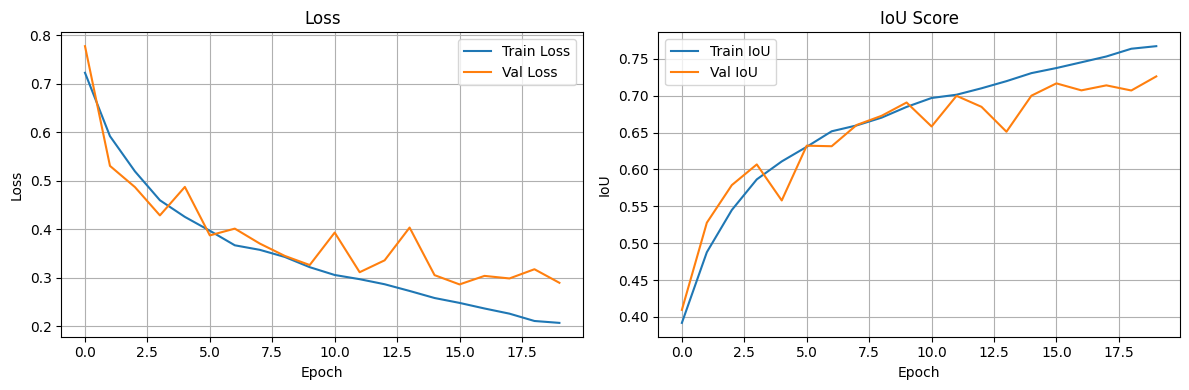

Results saved as 'training_results.png'


In [25]:
# Plot metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

print("Results saved as 'training_results.png'")

## Load pretrain model and evaluation

In [26]:
from PIL import Image

# Load trained model
model = UNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True)
model.load_state_dict(torch.load('unet_model.pth', map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully!")

# ==================== Load Test Dataset ====================

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.PILToTensor(),
])

test_dataset = OxfordIIITPet(
    root='./data',
    split='test',
    target_types='segmentation',
    download=True,
    transform=transform,
    target_transform=target_transform
)

print(f"Test dataset loaded: {len(test_dataset)} images")

# ==================== Prediction Function ====================

def predict_single_image(model, image_tensor, device):
    """Predict mask for a single image"""
    model.eval()
    with torch.no_grad():
        image_input = image_tensor.unsqueeze(0).to(device)
        output = model(image_input)
        prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    return prediction


def calculate_iou_single(pred, target, num_classes=3):
    """Calculate IoU for a single prediction"""
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()

        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        ious.append(iou)

    return np.mean(ious), ious


def mask_to_rgb(mask, background_color='blue'):
    """Convert mask to RGB for visualization"""
    mask_rgb = np.zeros((*mask.shape, 3))
    mask_rgb[mask == 0] = [1, 0, 0]      # Red - Pet
    mask_rgb[mask == 1] = [1, 1, 0]      # Yellow - Border
    mask_rgb[mask == 2] = [0, 0, 1]      # Blue - Background
    return mask_rgb


# ==================== Visualize Multiple Predictions ====================

def visualize_predictions(model, dataset, device, num_samples=6):
    """Visualize predictions vs ground truth"""

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    # Random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]

        # Predict
        prediction = predict_single_image(model, image, device)

        # Convert mask to numpy and adjust indices
        mask_np = mask.squeeze().numpy() - 1  # Convert {1,2,3} to {0,1,2}

        # Calculate IoU
        mean_iou, class_ious = calculate_iou_single(prediction, mask_np, NUM_CLASSES)

        # Convert to RGB
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_rgb = mask_to_rgb(mask_np)
        pred_rgb = mask_to_rgb(prediction)

        # Create difference map (red = wrong, green = correct)
        diff_map = np.zeros_like(mask_rgb)
        correct = (prediction == mask_np)
        diff_map[correct] = [0, 1, 0]    # Green - Correct
        diff_map[~correct] = [1, 0, 0]   # Red - Wrong

        # Plot
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f'Sample {idx}: Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_rgb)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_rgb)
        axes[i, 2].set_title(f'Prediction\nIoU: {mean_iou:.3f}')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(diff_map)
        axes[i, 3].set_title('Difference\n(Green=Correct, Red=Wrong)')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved as 'predictions_comparison.png'")


# ==================== Predict on Custom Image ====================

def predict_custom_image(model, image_path, device):
    """Predict mask for a custom image file"""

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    image_tensor = transform(image)

    # Predict
    prediction = predict_single_image(model, image_tensor, device)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    pred_rgb = mask_to_rgb(prediction)

    axes[0].imshow(image_np)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(pred_rgb)
    axes[1].set_title('Predicted Mask\n(Red=Pet, Yellow=Border, Blue=Bg)')
    axes[1].axis('off')

    axes[2].imshow(image_np)
    axes[2].imshow(pred_rgb, alpha=0.5)
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('custom_prediction.png', dpi=300, bbox_inches='tight')
    plt.show()

    return prediction


# ==================== Evaluate on Test Set ====================

def evaluate_test_set(model, dataset, device):
    """Calculate average IoU on entire test set"""

    print("Evaluating on test set...")
    total_iou = 0.0
    class_ious = np.zeros(NUM_CLASSES)

    for i in range(len(dataset)):
        image, mask = dataset[i]

        # Predict
        prediction = predict_single_image(model, image, device)
        mask_np = mask.squeeze().numpy() - 1

        # Calculate IoU
        mean_iou, ious = calculate_iou_single(prediction, mask_np, NUM_CLASSES)
        total_iou += mean_iou
        class_ious += ious

        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{len(dataset)} images...")

    avg_iou = total_iou / len(dataset)
    avg_class_ious = class_ious / len(dataset)

    print("\n" + "="*50)
    print("Test Set Results:")
    print(f"  Mean IoU: {avg_iou:.4f}")
    print(f"  Pet IoU: {avg_class_ious[0]:.4f}")
    print(f"  Border IoU: {avg_class_ious[1]:.4f}")
    print(f"  Background IoU: {avg_class_ious[2]:.4f}")
    print("="*50)

    return avg_iou, avg_class_ious

Model loaded successfully!
Test dataset loaded: 3669 images



1. Visualizing random predictions from test set...


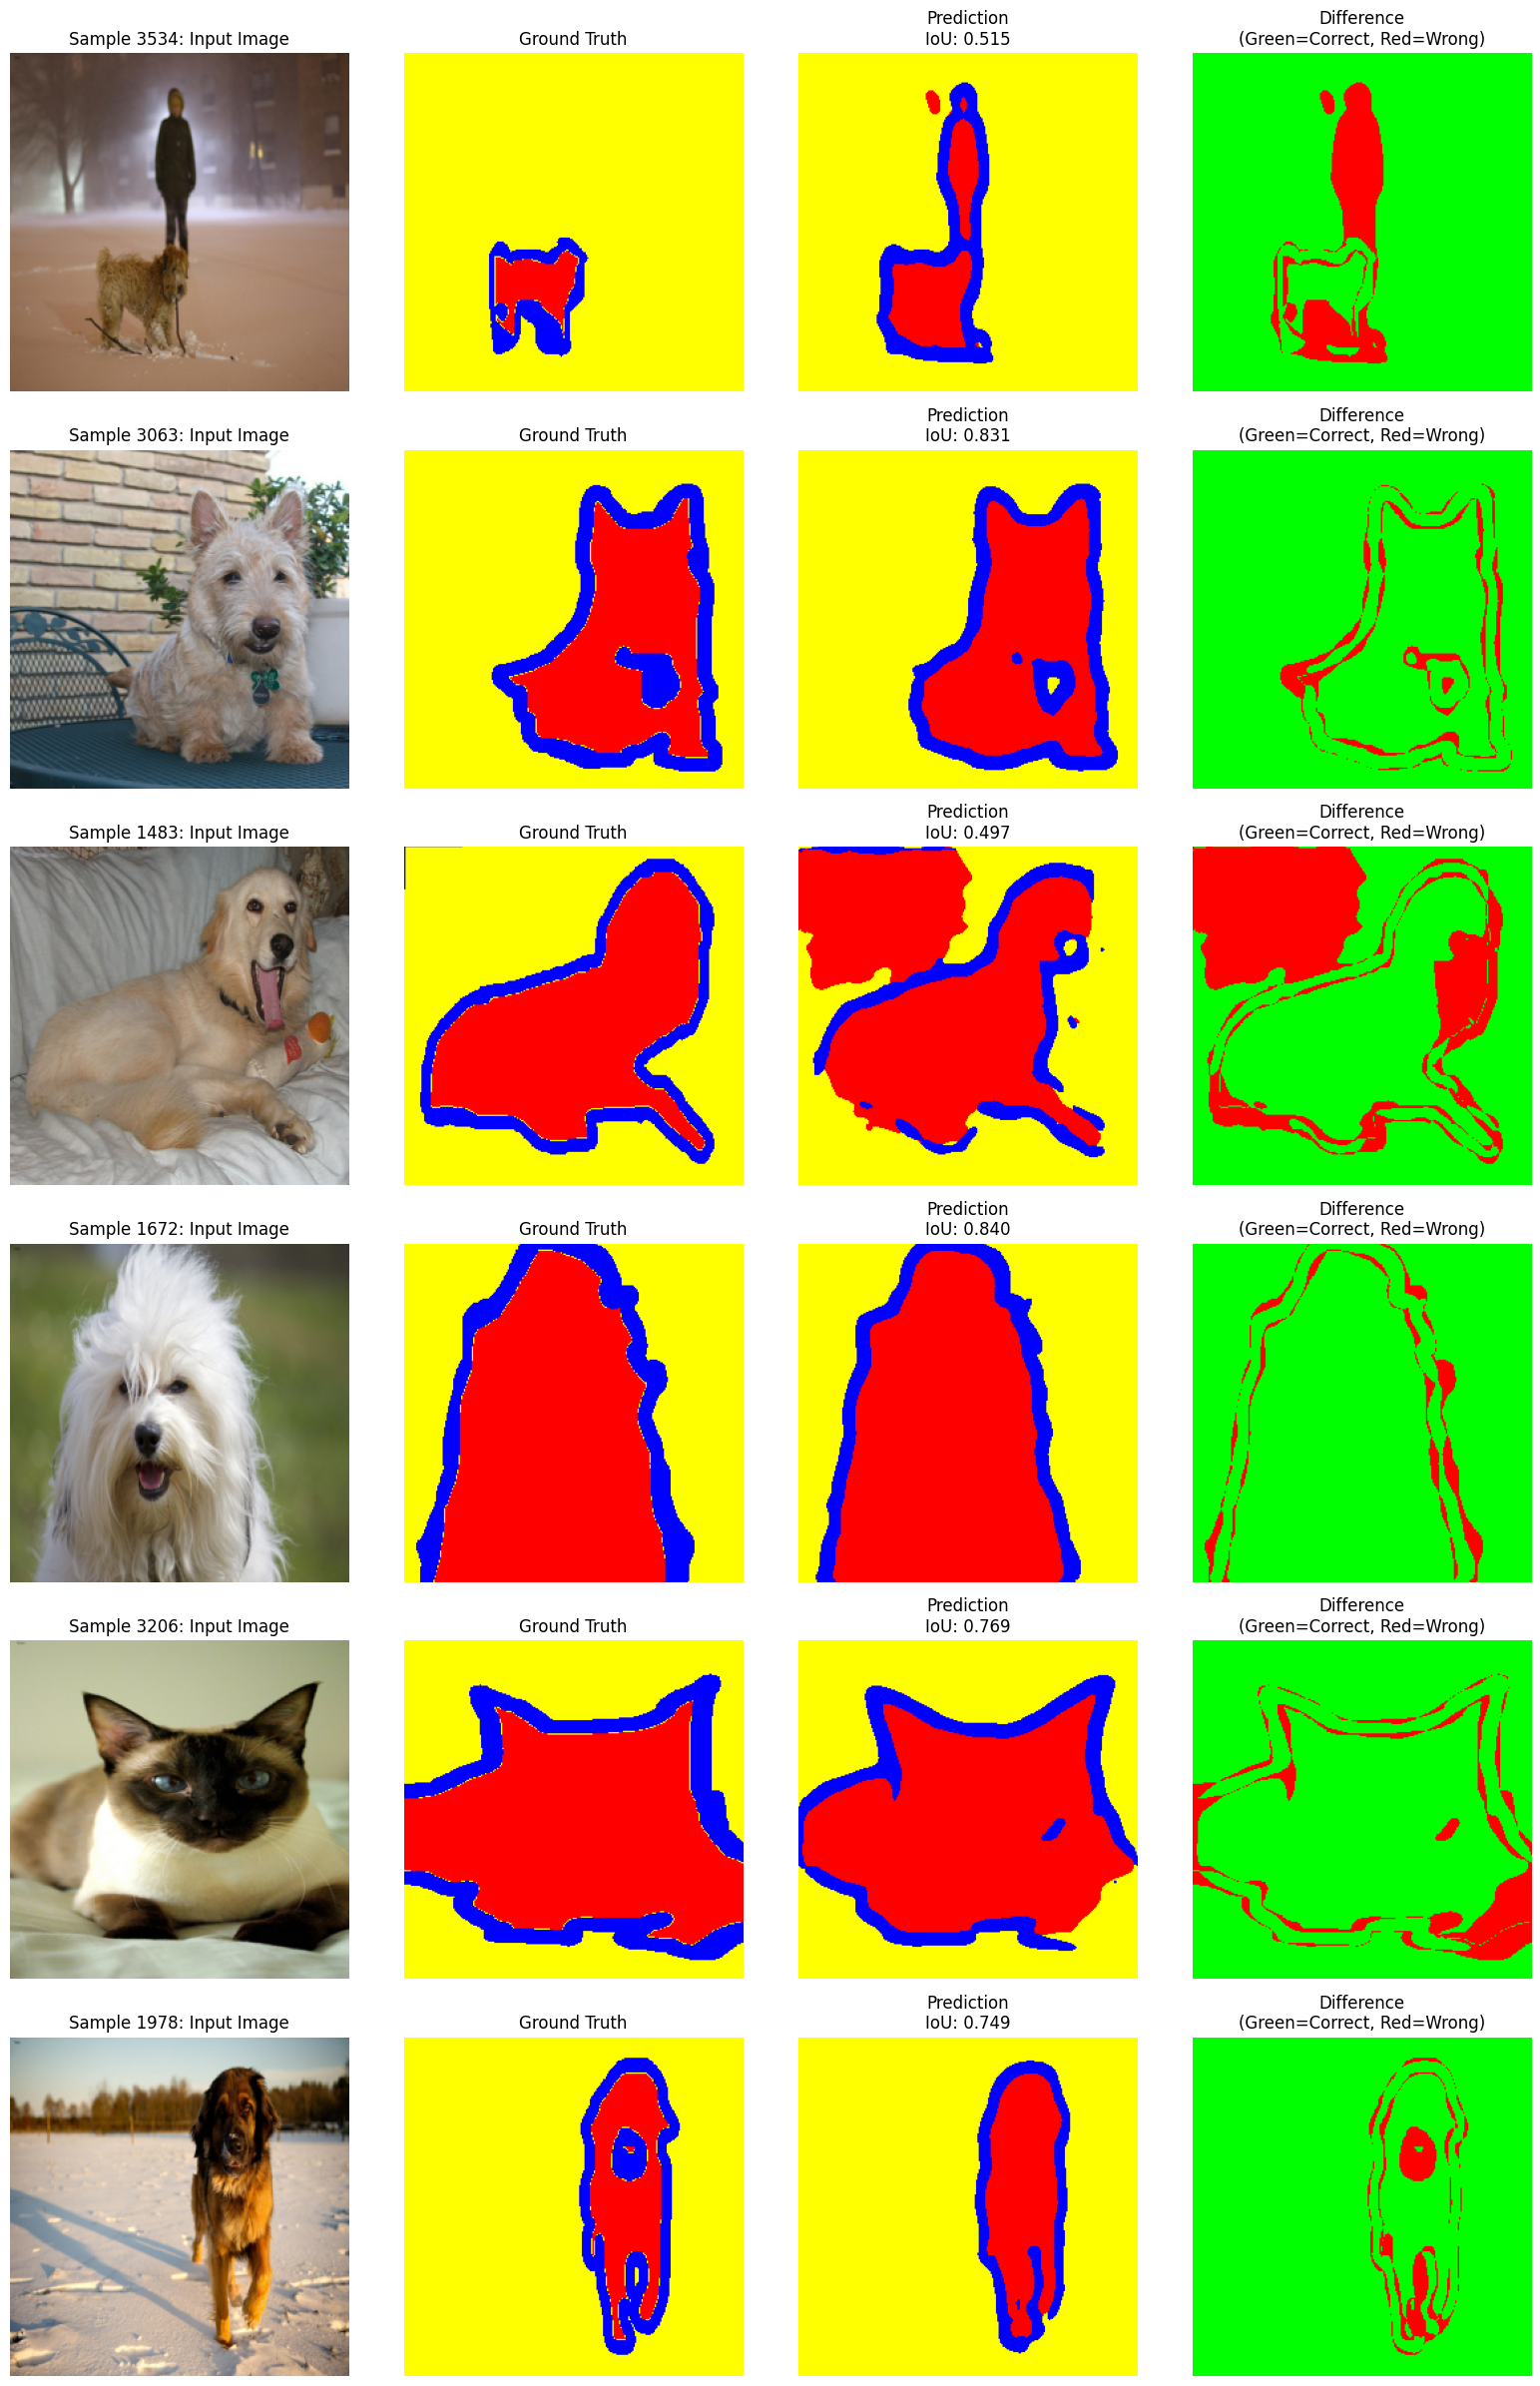

Saved as 'predictions_comparison.png'

2. Evaluating on full test set...
Evaluating on test set...
Processed 100/3669 images...
Processed 200/3669 images...
Processed 300/3669 images...
Processed 400/3669 images...
Processed 500/3669 images...
Processed 600/3669 images...
Processed 700/3669 images...
Processed 800/3669 images...
Processed 900/3669 images...
Processed 1000/3669 images...
Processed 1100/3669 images...
Processed 1200/3669 images...
Processed 1300/3669 images...
Processed 1400/3669 images...
Processed 1500/3669 images...
Processed 1600/3669 images...
Processed 1700/3669 images...
Processed 1800/3669 images...
Processed 1900/3669 images...
Processed 2000/3669 images...
Processed 2100/3669 images...
Processed 2200/3669 images...
Processed 2300/3669 images...
Processed 2400/3669 images...
Processed 2500/3669 images...
Processed 2600/3669 images...
Processed 2700/3669 images...
Processed 2800/3669 images...
Processed 2900/3669 images...
Processed 3000/3669 images...
Processed 

In [27]:
print("\n1. Visualizing random predictions from test set...")
visualize_predictions(model, test_dataset, device, num_samples=6)

print("\n2. Evaluating on full test set...")
evaluate_test_set(model, test_dataset, device)

# Uncomment to predict on custom image
# print("\n3. Predicting on custom image...")
# predict_custom_image(model, 'path/to/your/image.jpg', device)

print("\nDone!")